In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

For building roc curve

In [2]:
def build_roc_curve(false_positive_rate, true_positive_rate, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Read text data from file and set one hot encoding for product category and part of day of transactions.

In [3]:
def convertToDate(x):
    return datetime.fromtimestamp(int(x))
df = pd.read_csv('train_ds.csv',
                   sep=',', header=0,
                   names=['cgsettlementbufferid', 'mcc','ccy', 'tranccy', 'amount', 'location', 'trandatetime', 'sexid', 'clientid'],
                   converters = {'trandatetime': convertToDate},
                   dtype={'sexid': np.bool_,
                          'cgsettlementbufferid': np.int32,
                          'mcc': np.int32,
                          'ccy': np.int32,
                          'tranccy': np.int32,
                          'amount': np.int32,
                          'clientid': np.int32,
                          'location': np.string_
                         },
                  )
df_test = pd.read_csv('test_ds.csv',
                   sep=',', header=0,
                   names=['cgsettlementbufferid', 'mcc','ccy', 'tranccy', 'amount', 'location', 'trandatetime', 'clientid'],
                   converters = {'trandatetime': convertToDate},
                   dtype={
                          'cgsettlementbufferid': np.int32,
                          'mcc': np.int32,
                          'ccy': np.int32,
                          'tranccy': np.int32,
                          'amount': np.int32,
                          'clientid': np.int32,
                          'location': np.string_
                         },
                  )

In [5]:
def to_date_time_encoding(x):
    if x.hour < 9:
        return 0
    elif x.hour < 12:
        return 1
    elif x.hour < 15:
        return 2
    elif x.hour < 18:
        return 3
    else:
        return 4
df['Day_Time'] = df['trandatetime'].apply(to_date_time_encoding)
df_test['Day_Time'] = df_test['trandatetime'].apply(to_date_time_encoding)

In [6]:
df['region'] = df['location'].apply(lambda x: x[-2:])
df_test['region'] = df_test['location'].apply(lambda x: x[-2:])

In [7]:
d = pd.get_dummies(df[['Day_Time']], prefix=['d'], columns=['Day_Time'])
d_names = list(filter(lambda x: x.startswith('d_'), d.columns.values.tolist()))

r = pd.get_dummies(df[['region']], prefix=['r'], columns=['region'])
r_names = list(filter(lambda x: x.startswith('r_'), r.columns.values.tolist()))

combined = pd.concat([df[['clientid', 'amount']], d, r], axis=1)
for name in d_names:
    combined[name] = combined[[name, 'amount']].apply(lambda x: x[1] if x[0] == 1 else 0, axis=1)
    
d_test = pd.get_dummies(df_test[['Day_Time']], prefix=['d'], columns=['Day_Time'])

r_test = pd.get_dummies(df_test[['region']], prefix=['r'], columns=['region'])
r_test_names = list(filter(lambda x: x.startswith('r_'), r_test.columns.values.tolist()))

combined_test = pd.concat([df_test[['clientid', 'amount']], d_test, r_test], axis=1)
for name in d_names:
    combined_test[name] = combined_test[[name, 'amount']].apply(lambda x: x[1] if x[0] == 1 else 0, axis=1)

In [10]:
mcc = pd.get_dummies(df[['mcc']], prefix=['mcc'], columns=['mcc'])
mcc_names = list(filter(lambda x: x.startswith('mcc_'), mcc.columns.values.tolist()))

mcc_test = pd.get_dummies(df_test[['mcc']], prefix=['mcc'], columns=['mcc'])
mcc_test_names = list(filter(lambda x: x.startswith('mcc_'), mcc_test.columns.values.tolist()))

In [20]:
mcc_common = list(set(mcc)&set(mcc_test))
region_common = list(set(r_names)&set(r_test_names))

In [21]:
info_df = pd.concat([df[['clientid', 'amount']],mcc[mcc_common],d,r[region_common]],axis=1)
for name in d_names:
    print(name)
    for m in mcc_common:
        info_df[str(m)+'_'+str(name)]=info_df[[name,m,'amount']].apply(lambda x: x[2] if x[1] == 1 and x[0] ==1 else 0,axis=1)

d_0
d_1
d_2
d_3
d_4


In [34]:
info_df_test = pd.concat([df_test[['clientid', 'amount']],mcc_test[mcc_common],d_test],axis=1)
for name in d_names:
    print(name)
    for m in mcc_common:
        info_df_test[str(m)+'_'+str(name)]=info_df_test[[name,m,'amount']].apply(lambda x: x[2] if x[1] == 1 and x[0] ==1 else 0,axis=1)

d_0
d_1
d_2
d_3
d_4


In [26]:
names = ['clientid', 'amount']
#names_r = ['clientid', 'amount']

names.extend(d_names)
#names_r.extend(region_common)

aggregation = {
    'amount': ['sum', 'mean', 'max'],
}

for name in d_names:
    aggregation[name] = ['sum', 'mean', 'max']
    
#for name in region_common:
    #aggregation[name] = ['sum']

grp = combined[names].groupby('clientid').agg(aggregation).reset_index()
#grp_r = combined[names_r].groupby('clientid').agg(aggregation).reset_index()

In [36]:
names_test = ['clientid', 'amount']
#names_r_test = ['clientid', 'amount']

names_test.extend(d_names)
#names_r_test.extend(region_common)

aggregation = {
    'amount': ['sum', 'mean', 'max'],
}

for name in d_names:
    aggregation[name] = ['sum', 'mean', 'max']
    
#for name in region_common:
    #aggregation[name] = ['sum']

grp_test = combined_test[names_test].groupby('clientid').agg(aggregation).reset_index()
#grp_r_test = combined_test[names_test].groupby('clientid').agg(aggregation).reset_index()

In [27]:
user_info = df.drop_duplicates('clientid')[['sexid', 'clientid']]
#user_info_test = df_test.drop_duplicates('clientid')[['clientid']]

In [38]:
user_info_test = df_test.drop_duplicates('clientid')[['clientid']]

In [28]:
user_info_new = pd.merge(user_info, info_df, on=['clientid', 'clientid'], how='right')
user_info_new = pd.merge(user_info_new, grp, on=['clientid', 'clientid'], how='right')
user_info_new.head()

/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.right = self.right.drop(right_drop, axis=1)


,sexid,clientid,amount,mcc_5422,mcc_5814,mcc_5950,mcc_5199,mcc_5734,mcc_5541,mcc_8071,...,"(d_1, max)","(d_2, sum)","(d_2, mean)","(d_2, max)","(d_3, sum)","(d_3, mean)","(d_3, max)","(d_4, sum)","(d_4, mean)","(d_4, max)"
0,True,13,6730,0,0,0,0,0,0,0,...,361550,10630469,25431.744019,1824211,10805724,25851.014354,1272130,6741051,16126.916268,622949
1,True,13,55912,0,0,0,0,0,0,0,...,361550,10630469,25431.744019,1824211,10805724,25851.014354,1272130,6741051,16126.916268,622949
2,True,13,135658,0,0,0,0,0,0,0,...,361550,10630469,25431.744019,1824211,10805724,25851.014354,1272130,6741051,16126.916268,622949
3,True,13,138294,0,0,0,0,0,0,0,...,361550,10630469,25431.744019,1824211,10805724,25851.014354,1272130,6741051,16126.916268,622949
4,True,13,426209,0,0,0,0,0,0,0,...,361550,10630469,25431.744019,1824211,10805724,25851.014354,1272130,6741051,16126.916268,622949


In [39]:
user_info_new_test = pd.merge(user_info_test, info_df_test, on=['clientid', 'clientid'], how='right')
user_info_new_test = pd.merge(user_info_new_test, grp_test, on=['clientid', 'clientid'], how='right')
user_info_new_test.head()

/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.right = self.right.drop(right_drop, axis=1)


,clientid,amount,mcc_5422,mcc_5814,mcc_5950,mcc_5199,mcc_5734,mcc_5541,mcc_8071,mcc_7995,...,"(d_1, max)","(d_2, sum)","(d_2, mean)","(d_2, max)","(d_3, sum)","(d_3, mean)","(d_3, max)","(d_4, sum)","(d_4, mean)","(d_4, max)"
0,712,7488,0,0,0,0,0,0,0,0,...,1461900,12862225,15422.332134,1629964,21811353,26152.701439,1500000,42138642,50525.94964,12000000
1,712,20614,0,0,0,0,0,0,0,0,...,1461900,12862225,15422.332134,1629964,21811353,26152.701439,1500000,42138642,50525.94964,12000000
2,712,79200,0,0,0,0,0,0,0,0,...,1461900,12862225,15422.332134,1629964,21811353,26152.701439,1500000,42138642,50525.94964,12000000
3,712,12058,0,0,0,0,0,0,0,0,...,1461900,12862225,15422.332134,1629964,21811353,26152.701439,1500000,42138642,50525.94964,12000000
4,712,5652,0,0,0,0,0,0,0,0,...,1461900,12862225,15422.332134,1629964,21811353,26152.701439,1500000,42138642,50525.94964,12000000


In [65]:
user_info_new = user_info_new.drop(r[region_common],axis=1)

1225

In [92]:
train, test = train_test_split(user_info_new, test_size=0.3)
train_X = train.loc[:, train.columns != 'sexid'].groupby('clientid').mean() 
test_X = test.loc[:, test.columns != 'sexid'].groupby('clientid').mean()
train_Y = train.groupby('clientid').mean().sexid
test_Y = test.groupby('clientid').mean().sexid

# Random Forest

fpr: [ 0.          0.40713407  1.        ]
tpr: [ 0.          0.88930233  1.        ]
auc: 0.74108412712
             precision    recall  f1-score   support

      False       0.80      0.59      0.68       813
       True       0.74      0.89      0.81      1075

avg / total       0.77      0.76      0.75      1888

accuracy: 0.761652542373


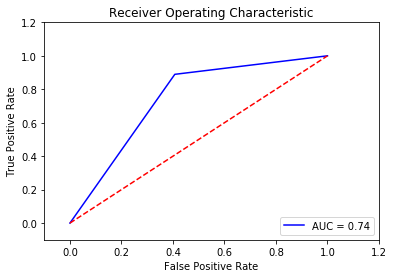

In [144]:

clf = RandomForestClassifier(n_estimators=400, min_samples_split=5,n_jobs=-1)
y_pred = clf.fit(train_X, train_Y).predict(test_X)

fpr, tpr, thresholds = roc_curve(test_Y, y_pred)
model_auc = auc(fpr, tpr)
print('fpr:', fpr)
print('tpr:', tpr)
print('auc:', model_auc)
print(classification_report(test_Y, y_pred))
print('accuracy:', accuracy_score(test_Y, y_pred))
build_roc_curve(fpr, tpr, model_auc)

In [145]:
clf.feature_importances_

array([ 0.02902023,  0.00014018,  0.00289697, ...,  0.0196201 ,
        0.01927803,  0.01842503])

In [146]:
prediction_test = clf.predict(user_info_new_test.groupby('clientid').mean())

In [147]:
res_df = pd.DataFrame({'clientid':user_info_new_test.groupby('clientid')['clientid'].mean(),'sexid':prediction_test})
res_df['sexid'] = res_df['sexid'].apply(lambda x: 1 if x else 0)
res_df.to_csv('result.csv',sep=',',columns=['sexid'])

# Gradient Boosting

fpr: [ 0.          0.50307503  1.        ]
tpr: [ 0.         0.8055814  1.       ]
auc: 0.651253182299
             precision    recall  f1-score   support

      False       0.66      0.50      0.57       813
       True       0.68      0.81      0.74      1075

avg / total       0.67      0.67      0.66      1888

accuracy: 0.672669491525


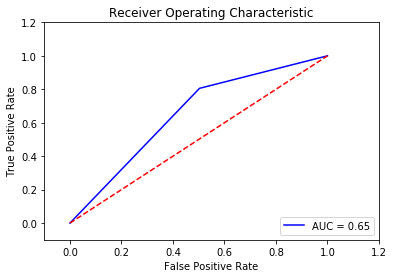

In [105]:
clf_b = GradientBoostingClassifier()
y_pred = clf_b.fit(train_X, train_Y).predict(test_X)

fpr, tpr, thresholds = roc_curve(test_Y, y_pred)
model_auc = auc(fpr, tpr)
print('fpr:', fpr)
print('tpr:', tpr)
print('auc:', model_auc)
print(classification_report(test_Y, y_pred))
print('accuracy:', accuracy_score(test_Y, y_pred))
build_roc_curve(fpr, tpr, model_auc)

# Test example

##### Second task

In [155]:
from DateTime import DateTime
x = DateTime('2015/7/6 00:01am EET').timeTime()
y = DateTime('2015/7/6 11:59pm EET').timeTime()
june = DateTime('2015/6/1 00:01pm EET').timeTime()
june_end = DateTime('2015/6/30 11:59pm EET').timeTime()
start = DateTime('2015/7/1 00:01am EET').timeTime()
file = pd.read_csv('train_ds.csv',sep = ',')
file_val = file.values
fl = 0 
users = []
for i in file_val:
    if i[6]>x and i[6]<y and DateTime(i[6]).parts()[3]>17 and ('KIYEV' in i[5] or 'KYIV' in i[5] or 'KUIV' in i[5]) and i[1]==5812:
        print(DateTime(i[6]).parts(),i[8])
        fl = 0
        print('===============================')
        for j in file.loc[file['clientid']==i[8]].values:
            #if 'UA' not in j[5]:
                #print( j[5], DateTime(j[6]).parts(), j[1])
            #print(j[5],DateTime(j[6]).parts())
            if (j[1]==4511 or (j[1]>=3000 and j[1]<=3299)):#j[6]<start:
                print( j[5], DateTime(j[6]).parts(), j[8])
                fl = 1
        if fl == 1:
            for j in file.loc[file['clientid']==i[8]].values:
                if 'UA' in j[5] and j[6]>june and j[6]<june_end:
                    #print(DateTime(j[6]).parts(), j[8], j[5],j[4],j[3],j[2])
                    fl=0
            if fl==1:
                users.append(i[8])
        
        print('+++++++++++++++++++++++++++++++')
print(users)
print("John Dow's id: 2164 and he bought tikets in WIZZ AIR HUN920WZZP9KVJ BUDAPEST HU, so he lives in Hungary Budapest")

(2015, 7, 6, 22, 57, 59, 'GMT+3') 5273
+++++++++++++++++++++++++++++++
(2015, 7, 6, 19, 27, 53, 'GMT+3') 2164
WWW.WIZZAIR.COM        KIEV           UA (2015, 2, 8, 16, 41, 32, 'GMT+2') 2164
WWW.WIZZAIR.COM        KIEV           UA (2015, 2, 8, 0, 0, 0, 'GMT+2') 2164
LUFTHANSA   22081903964KIEV           UA (2015, 3, 28, 14, 48, 55, 'GMT+2') 2164
WIZZ AIR HUN920WZZP9KVJBUDAPEST       HU (2015, 5, 29, 0, 57, 8, 'GMT+3') 2164
+++++++++++++++++++++++++++++++
(2015, 7, 6, 21, 37, 51, 'GMT+3') 6617
+++++++++++++++++++++++++++++++
(2015, 7, 6, 22, 46, 51, 'GMT+3') 5293
+++++++++++++++++++++++++++++++
(2015, 7, 6, 21, 55, 37, 'GMT+3') 6655
+++++++++++++++++++++++++++++++
(2015, 7, 6, 20, 6, 0, 'GMT+3') 6474
+++++++++++++++++++++++++++++++
[]
John Dow's id: 2164 and he bought tikets in WIZZ AIR HUN920WZZP9KVJ BUDAPEST HU, so he lives in Hungary Budapest
